In [1]:
import platform
import os
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
    ROOT_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Thesis"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"
    ROOT_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis"

current_wd = os.getcwd()

In [2]:
import pandas as pd
import numpy as np
import torch
import pickle
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
import warnings
warnings.filterwarnings('ignore')
from matplotlib import rc
rc('text', usetex=True)

# Import the project_boundary function from InterFaceGAN
from project_boundary import project_boundary

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
save_path = f"{DATA_PATH}/Models/InterfaceGAN/Inputs/entangled_typicality/"
# Import metadata
meta = pd.read_json(f'{DATA_PATH}/Zalando_Germany_Dataset/dresses/metadata/dresses_metadata.json').T.reset_index().rename(columns={'index':'sku'})
# Rename "3/4 length" to "34 length" to avoid problems in path definitions
meta['sleeve_length'] = meta['sleeve_length'].replace('3/4 length', '34 length')
# Import typicality scores and merge to metadata
typicality_scores = pickle.load(open(f"{save_path}/typicality_scores.pkl", "rb"))
typicality_scores = pd.Series(typicality_scores)
typicality_scores.index.name = 'sku'
typicality_scores.name = 'typicality_score'

meta = meta.merge(typicality_scores, on='sku')
meta.head(3)

sku                                               name  \
0  AN621C22S-O11                               Jersey dress - brown   
1  BU321C01G-K11                     Jersey dress - marine/bedruckt   
2  JY121C0TB-A11  JDYCARLA CATHINKA DRESS - Jersey dress - cloud...   

    sku_base sku_color_code  \
0  AN621C22S            O11   
1  BU321C01G            K11   
2  JY121C0TB            A11   

                                                 url       brand  \
0  https://en.zalando.de/anna-field-shift-dress-b...  Anna Field   
1  https://en.zalando.de/buffalo-jersey-dress-mar...     Buffalo   
2  https://en.zalando.de/jdy-carla-cathinka-dress...         JDY   

  original_price current_price                                  brand_url  \
0          39.99         39.99          https://en.zalando.de/anna-field/   
1          39.99         39.99             https://en.zalando.de/buffalo/   
2          34.99         34.99  https://en.zalando.de/jacqueline-de-yong/   

       category  ...          fit        neckline pattern           collar  \
0   Shift dress  ...     Slim Fit            None   Plain  Standing collar   
1  Jersey dress  ...  Regular Fit  Low-cut v-neck   Print             None   
2  Jersey dress  ...  Regular Fit       Crew neck   Plain  Standing collar   

        length         shape sleeve_length  \
0  Calf-length  Body-hugging         Short   
1  Knee-length        Fitted    Sleeveless   
2  Knee-length        Flared         Short   

                                       thumbnail_url  \
0  https://img01.ztat.net/article/spp-media-p1/fb...   
1  https://img01.ztat.net/article/spp-media-p1/50...   
2  https://img01.ztat.net/article/spp-media-p1/20...   

                                        packshot_url typicality_score  
0  https://img01.ztat.net/article/spp-media-p1/c8...         0.823655  
1  https://img01.ztat.net/article/spp-media-p1/17...         0.807152  
2  https://img01.ztat.net/article/spp-media-p1/20...         0.776698  

[3 rows x 23 columns]

### Helper Functions

In [5]:
def tensor2im(var):
    var = var.cpu().detach().transpose(0, 2).transpose(0, 1).numpy()
    var = ((var + 1) / 2)
    var[var < 0] = 0
    var[var > 1] = 1
    var = var * 255
    return Image.fromarray(var.astype('uint8'))

In [6]:
def setup_generator():
    os.chdir(f"{ROOT_PATH}/stylegan2-ada-pytorch")
    # Load model architecture
    experiment_path = f"{DATA_PATH}/Models/Stylegan2_Ada/Experiments/00005-stylegan2_ada_images-mirror-auto2-kimg5000-resumeffhq512/"
    model_name = "network-snapshot-001200.pkl"
    model_path = experiment_path + model_name
    with open(model_path, 'rb') as f:
        architecture = pickle.load(f)
        G = architecture['G_ema']
        D = architecture['D']
    os.chdir(current_wd)
    return G

G = setup_generator()

In [7]:
def generate_from_latent(latent):
    img = G.synthesis(latent, force_fp32=True, noise_mode = 'const')
    img = tensor2im(img.squeeze(0))
    return img

In [8]:
os.chdir(f"{ROOT_PATH}/2_Inversion/PTI/")
from pti_utils import load_pti
os.chdir(current_wd)

def generate_pti(latent, G_PTI):
    gen = G_PTI.synthesis(latent, noise_mode='const', force_fp32=True)
    img = tensor2im(gen.squeeze(0))
    return img

Using cpu as device


### Typicality Helper Functions

In [9]:
os.chdir(f"{ROOT_PATH}/4_Assessor/Dino/")
from dino_utils import get_embedding
os.chdir(current_wd)

Using cpu as device
Using cpu as device


In [10]:
# Get typicality morph
embeddings_path = f"{DATA_PATH}/Models/Assessor/DinoV2/Embeddings/e4e_embeddings_from_saved.pt"
embeddings_dict = torch.load(embeddings_path)
embeddings = torch.stack(list(embeddings_dict.values())).squeeze(1)
morph = embeddings.mean(axis = 0)


def calculate_typicality(img:Image):
    #Save image to temp
    img.save('temp.jpg')
    # Calculate dino embedding 
    embedding = get_embedding('temp.jpg')
    os.remove('temp.jpg')
    # Calculate cosine similarity
    similarity = torch.nn.functional.cosine_similarity(embedding.squeeze(0).cpu(), morph.cpu(), dim=0)
    return similarity

### InterFaceGAN Helper Functions

In [11]:
def get_interpolations(latent_code, start_distance, end_distance, steps, boundaries_base_dir):
    linspace = np.linspace(start_distance, end_distance, steps)

    # Repeat Latent for num_steps
    latent_code = latent_code.repeat(steps, 1, 1)

    boundary = np.load(f"{boundaries_base_dir}boundary_dim.npy")
    boundary = torch.tensor(boundary)
    for i in range(steps):
        latent_code[i, :, :] = latent_code[i, :, :] + linspace[i] * boundary
    
    return latent_code

In [12]:
def get_interpolations_conditional(latent_code, start_distance, end_distance, steps, boundaries_base_dir, condition_base_dir):
    linspace = np.linspace(start_distance, end_distance, steps)

    global boundary_orig 
    global boundary_np

    # Repeat Latent for num_steps
    latent_code = latent_code.repeat(steps, 1, 1)

    boundary_orig = np.load(f"{boundaries_base_dir}boundary_dim.npy")
    conditional_boundary = np.load(f"{condition_base_dir}/boundary_dim.npy")
    # Calculate conditional boundary
    boundary = project_boundary(boundary_orig, conditional_boundary)
    boundary_np = boundary
    boundary = torch.tensor(boundary)
    for i in range(steps):
        latent_code[i, :, :] = latent_code[i, :, :] + linspace[i] * boundary
    
    return latent_code

In [13]:
def run_example(n, direction = 'more', steps=5, distance=15, sku = None, generator = 'SG2', condition = None):

    boundaries_base_dir = f"{DATA_PATH}/Models/InterfaceGAN/Outputs/entangled_typicality/{n}/"

    # Load in training stats
    training_stats = pd.read_csv(f"{boundaries_base_dir}summary_stats.csv")

    # Load in original Latents
    latents = torch.load(f"{DATA_PATH}/Models/e4e/00005_snapshot_1200/inversions/latents_dict.pt")

    # Filter to include only SKU for which PTI exists
    pti_skus = list(glob('/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Models/PTI/experiments/embeddings/zalando_germany/PTI/*'))
    pti_skus = [elem.split('/')[-1] for elem in pti_skus]
    df = meta[meta.sku.isin(pti_skus)]
    global chosen_sku

    if sku: 
        chosen_sku = sku
    if generator == 'PTI':
        # Sample one latent
        sample = df.sample(1)
        if sku:
            sample = df[df.sku == sku]
        else: 
            sample = df.sample(1)
            chosen_sku = sample.sku.item()

        device = torch.device('cpu')
        G_PTI, latent = load_pti(chosen_sku)

        # Freeze and set to eval
        G_PTI.eval()
        for param in G_PTI.parameters():
            param.requires_grad = False

        # Send to CPU
        G_PTI = G_PTI.to(device)
        latent_code = latent.to(device)
        latent_code =latent_code.squeeze(0).flatten()

    elif generator == 'SG2':
        if sku:
            sample = df[df.sku == sku]
        else: 
            sample = df.sample(1)
            chosen_sku = sample.sku.item()
        latent_code = latents[sample.sku.item()].squeeze(0).flatten()

    # Generate Interpolations
    if direction == 'more': 
        start_distance, end_distance = 0, distance
    elif direction == 'less': 
        start_distance, end_distance = 0,  -distance

    if condition:
        # Get all boundaries for this condition and the prevalend attribute value in the sample
        all_conditional_boundaries = glob(f"{DATA_PATH}/Models/InterfaceGAN/Outputs/e4e_00005_concatenated/{condition}/*")
        all_conditional_boundaries = [elem for elem in all_conditional_boundaries if sample[condition].item() in elem]

        # Identify boundary with best separation performance
        dfs = []
        for path in all_conditional_boundaries: 
            try:
                dfs.append(pd.read_csv(f"{path}/summary_stats.csv"))
            except:
                pass

        best_boundary_idx = pd.concat(dfs).reset_index(drop=True).acc.idxmax()
        best_boundary_path = all_conditional_boundaries[best_boundary_idx]

        interpolations = get_interpolations_conditional(latent_code, start_distance, end_distance, steps, boundaries_base_dir, best_boundary_path)

    else: 
        interpolations = get_interpolations(latent_code, start_distance, end_distance, steps, boundaries_base_dir)

    if generator == 'SG2':
        imgs = [generate_from_latent(interpolations[i, :, :].squeeze(0).reshape(1,16,512)) for i in range(steps)]
    elif generator == 'PTI':
        imgs = [generate_pti(interpolations[i, :, :].squeeze(0).reshape(1,16,512), G_PTI) for i in range(steps)]



    # Add real image for comparison of first inversion
    real = Image.open(f"{DATA_PATH}/Zalando_Germany_Dataset/dresses/images/square_images/{chosen_sku}.jpg")

    imgs = [real] + imgs

    # Calculate typicality scores of generated images
    scores = [calculate_typicality(img) for img in imgs]

    fig, ax = plt.subplots(1, steps+1, figsize=(20, 5))
    ax = ax.ravel()
    for i in range(steps+1):
        ax[i].imshow(imgs[i])
        ax[i].axis('off')
            
        if i == 0: 
            ax[i].set_title(f'Original')
        elif i == 1: 
            ax[i].set_title(f'Inversion\nTypicality: {np.round(scores[i].item(), 2)}')
        else: 
            step = np.linspace(start_distance, end_distance, steps)[i-1]
            ax[i].set_title(f"{'+' if step > 0 else ''}{step}\nTypicality: {np.round(scores[i].item(), 2)}")

    
    fig.suptitle(f"SKU: {sample.sku.item()}\nDirection: {direction} typical\nGenerator type: " + r"\textbf{" + generator + "}")
    plt.show()

## Test e4e and PTI Manipulations Manipulations

In [14]:
# Filter to include only SKU for which PTI exists
pti_skus = list(glob('/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Models/PTI/experiments/embeddings/zalando_germany/PTI/*'))
pti_skus = [elem.split('/')[-1] for elem in pti_skus]
chosen_articles = meta[meta.sku.isin(pti_skus)].sample(3).sku.to_list()
print(chosen_articles)

['POT21C001-K13', 'BY221C0J2-B11', 'UR621C006-K11']


In [15]:
chosen_articles = ['ON321C38F-I11', 'KA321C13K-K11', 'YOD21C0T1-M11']

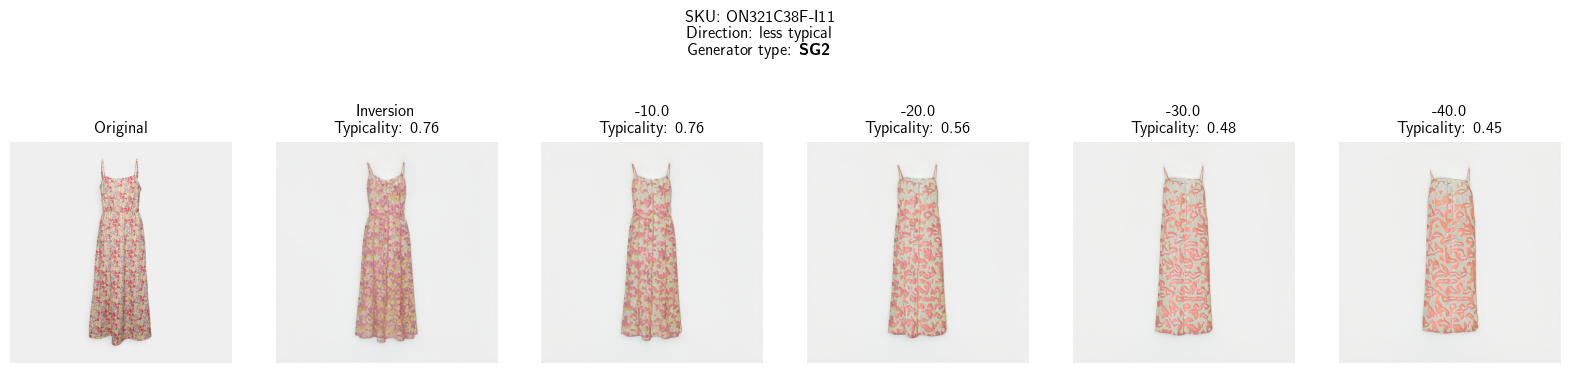

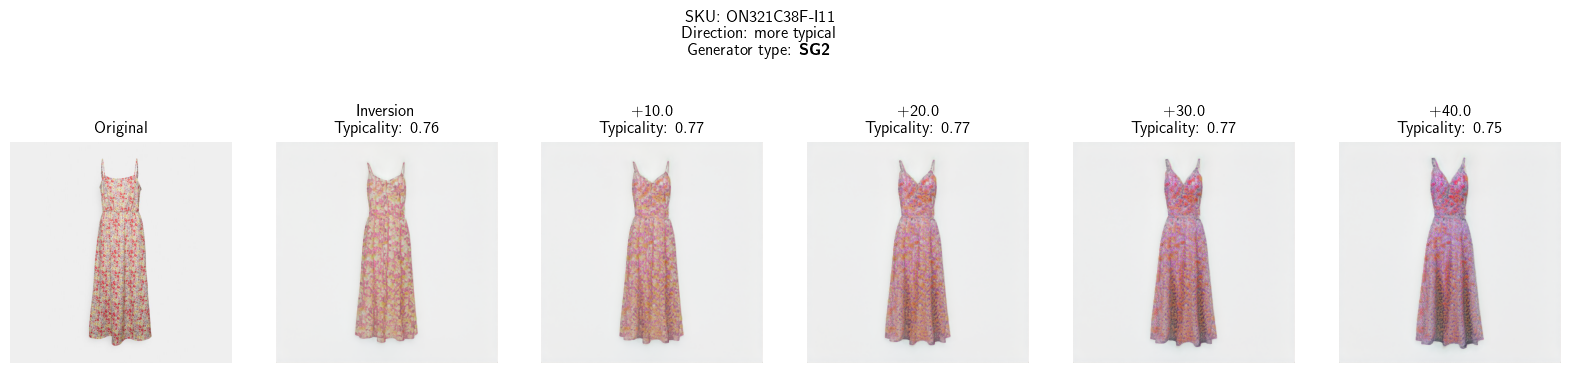

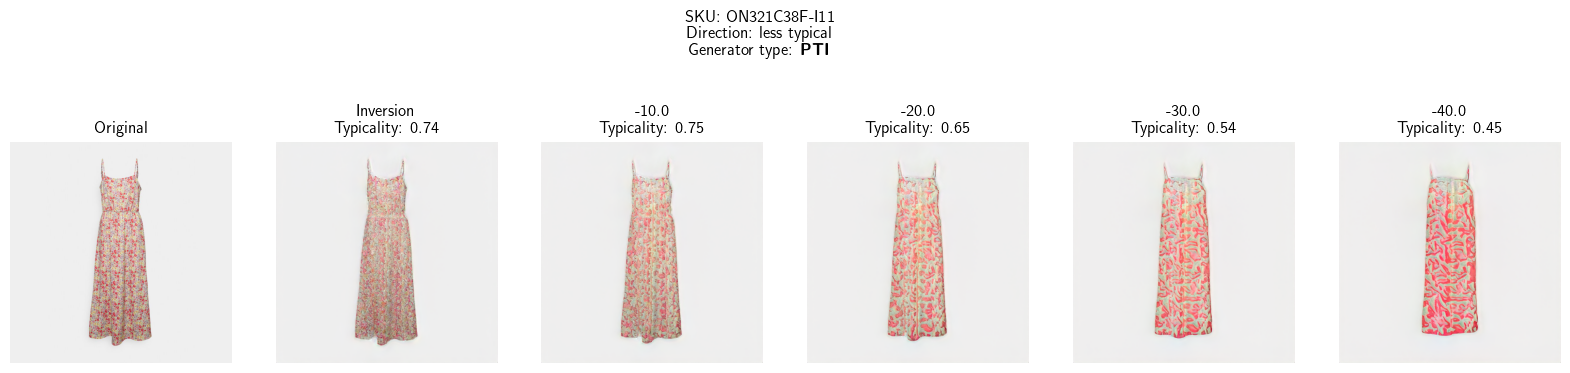

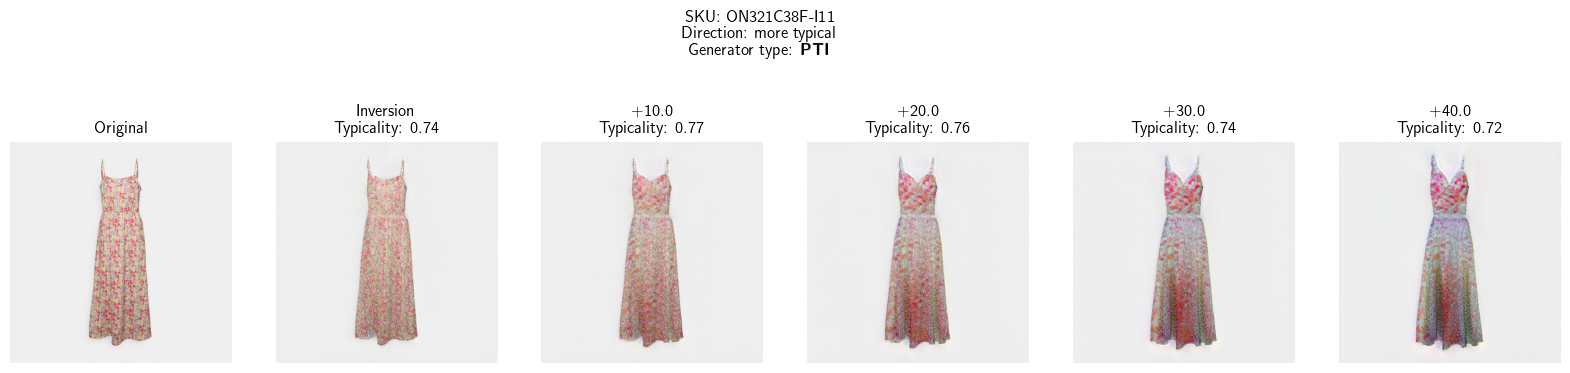


********************************************************************************************************************************************************************************************************



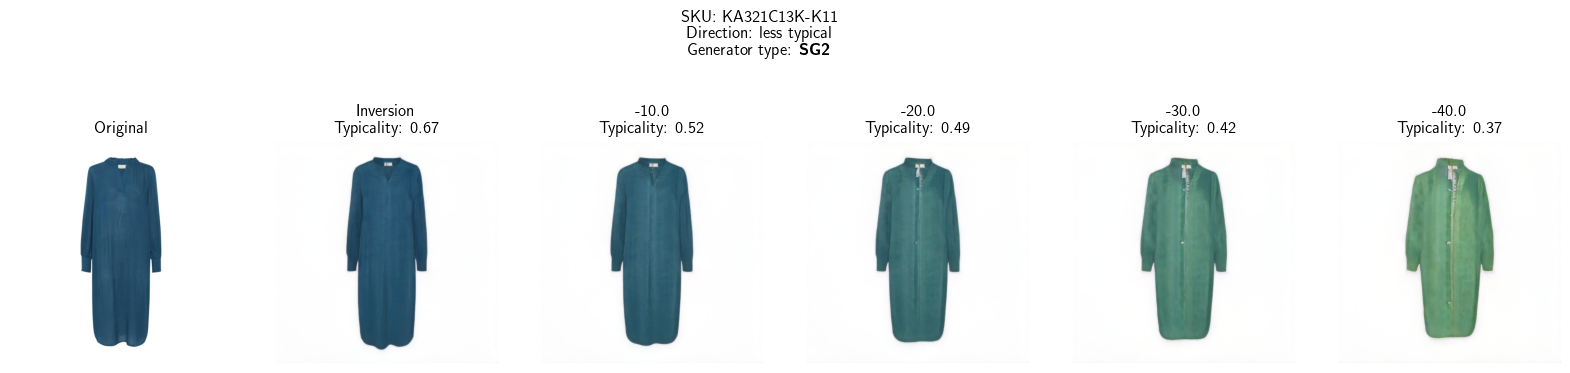

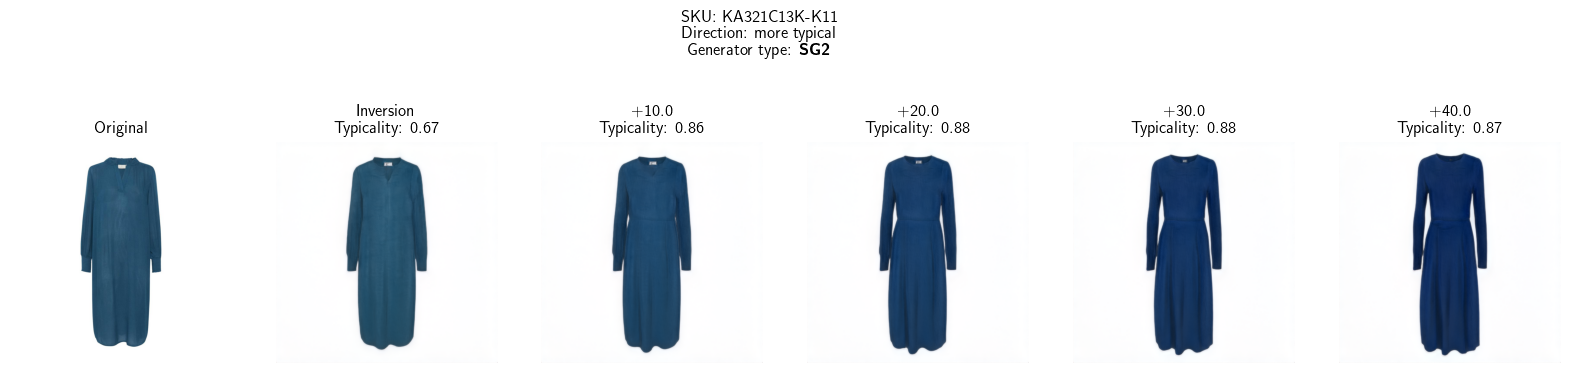

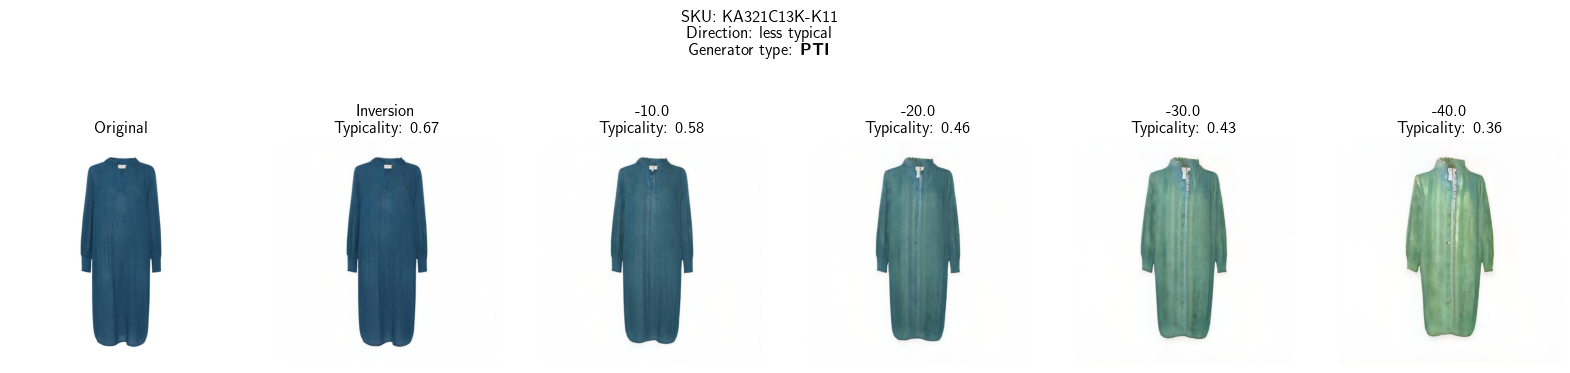

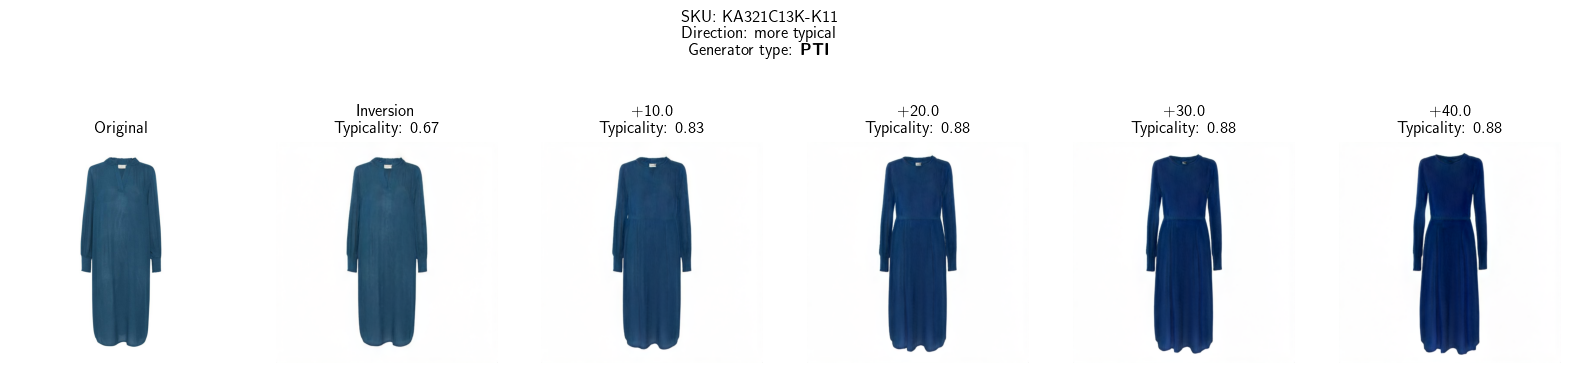


********************************************************************************************************************************************************************************************************



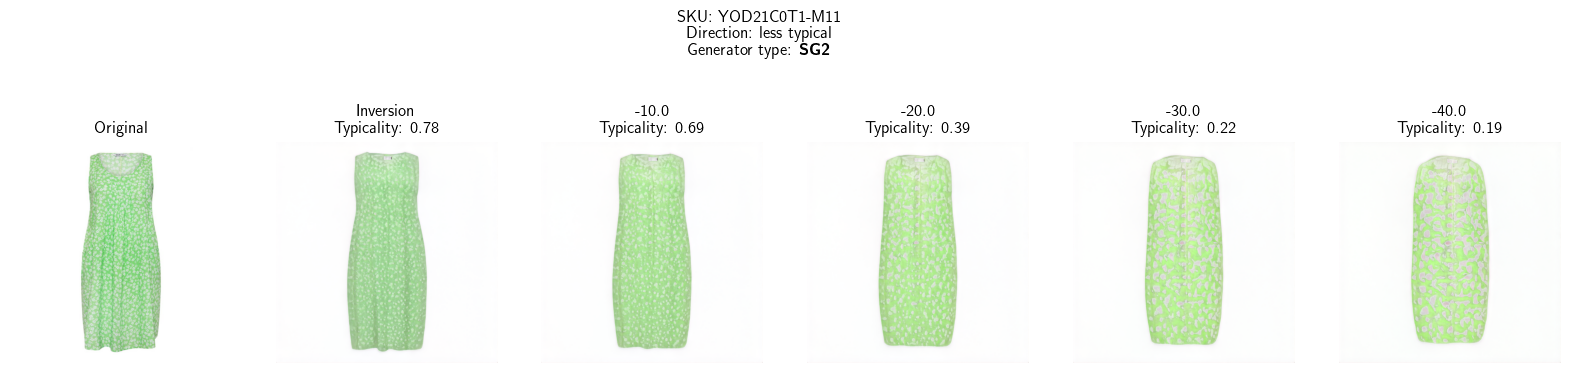

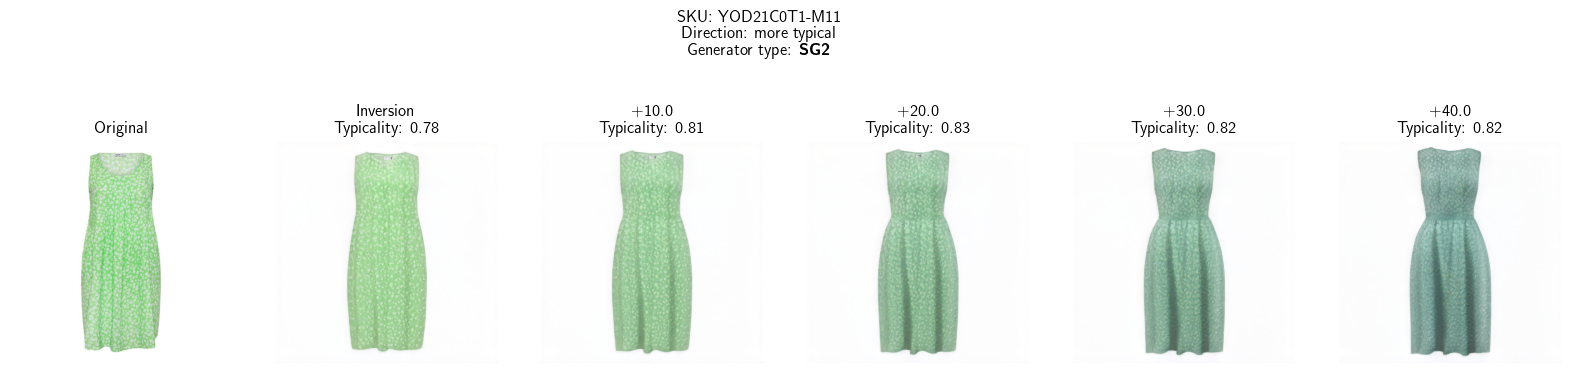

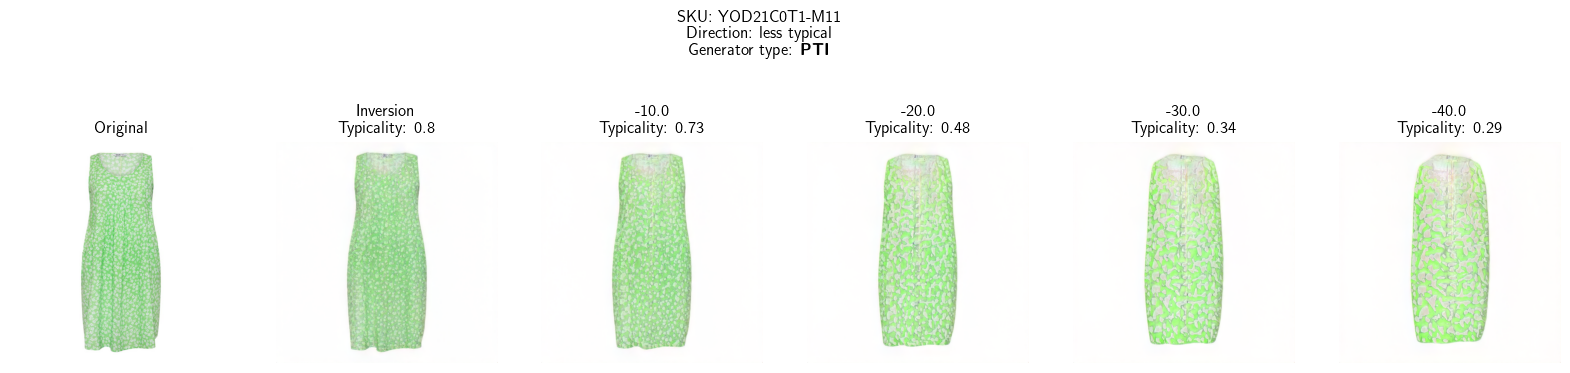

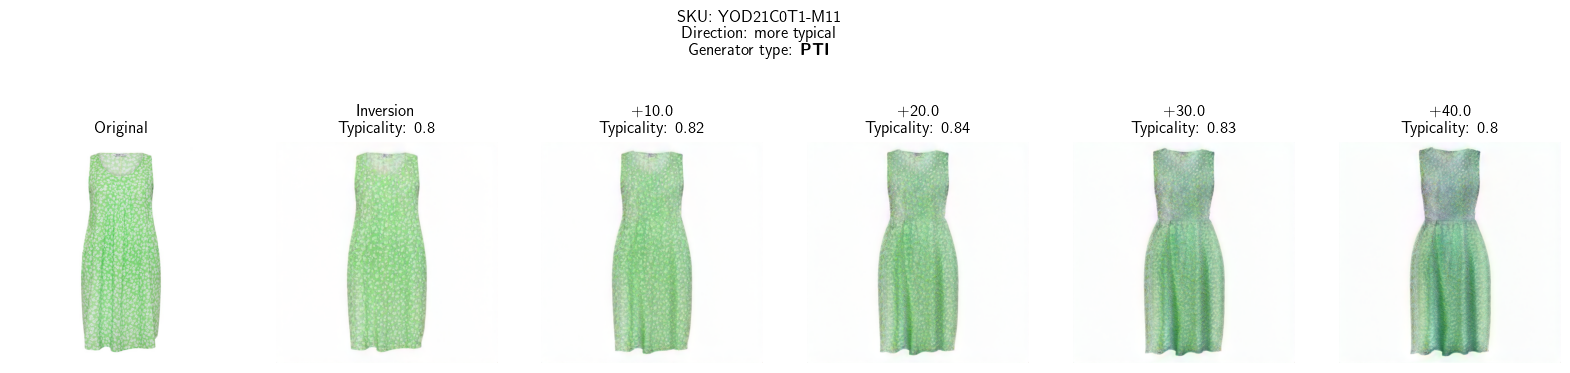


********************************************************************************************************************************************************************************************************



In [16]:
%matplotlib inline
for elem in chosen_articles:
    run_example(n = 1000, direction = 'less', steps=5, distance=40, sku = elem, generator = 'SG2')
    run_example(n = 1000, direction = 'more', steps=5, distance=40, sku = elem, generator = 'SG2')
    run_example(n = 1000, direction = 'less', steps=5, distance=40, sku = elem, generator = 'PTI')
    run_example(n = 1000, direction = 'more', steps=5, distance=40, sku = elem, generator = 'PTI')
    print(f"\n{'*'*200}\n")

### Test Smaller Range with More intermediate Steps

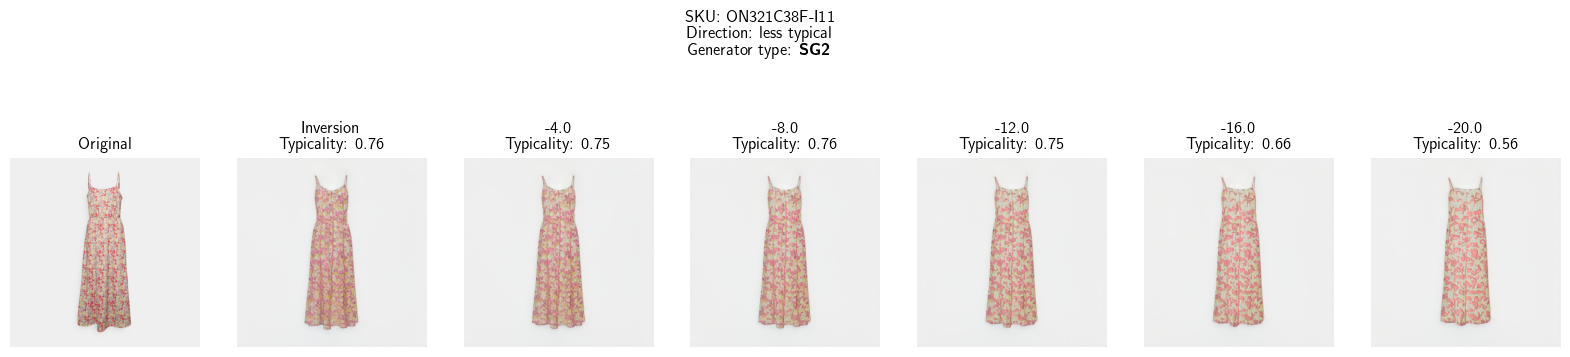

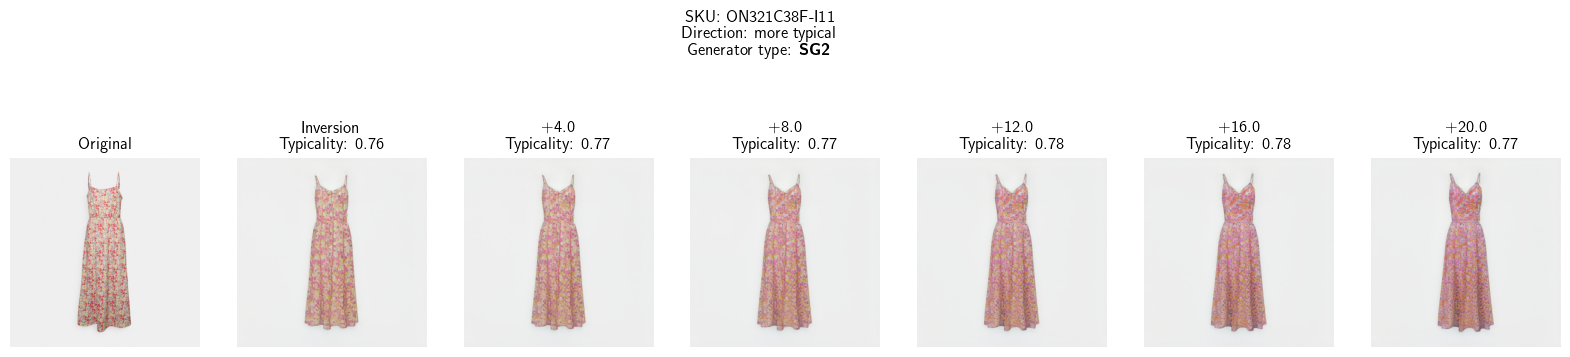

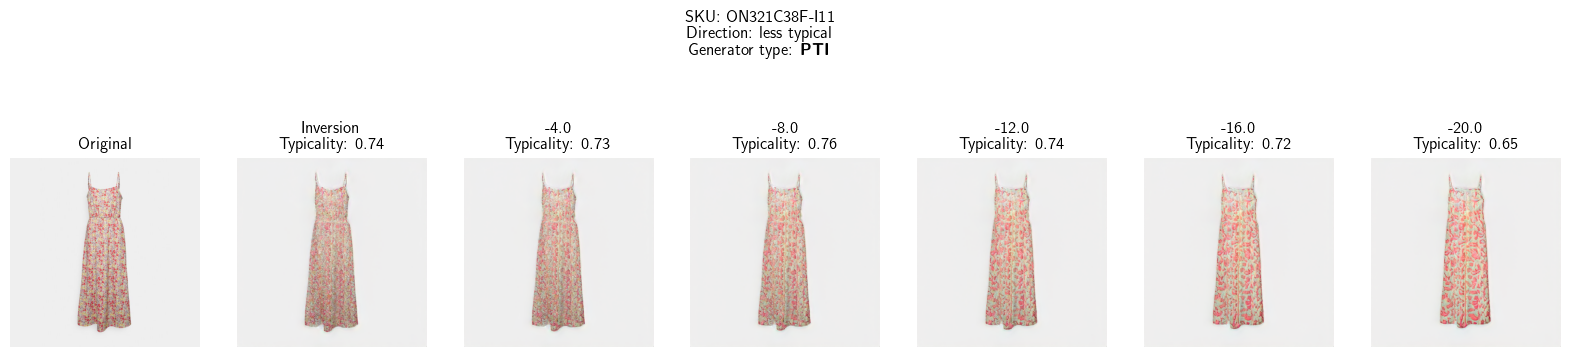

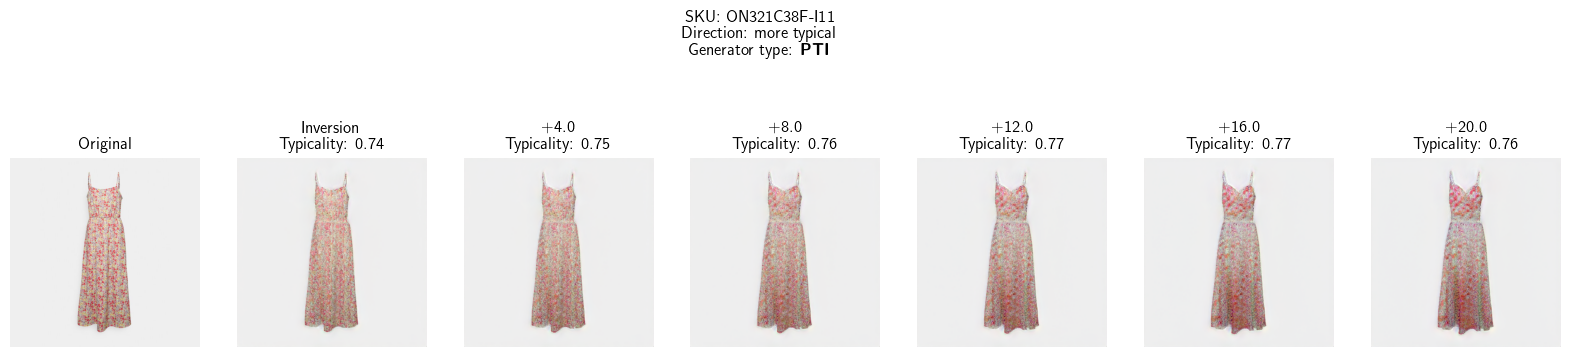


********************************************************************************************************************************************************************************************************



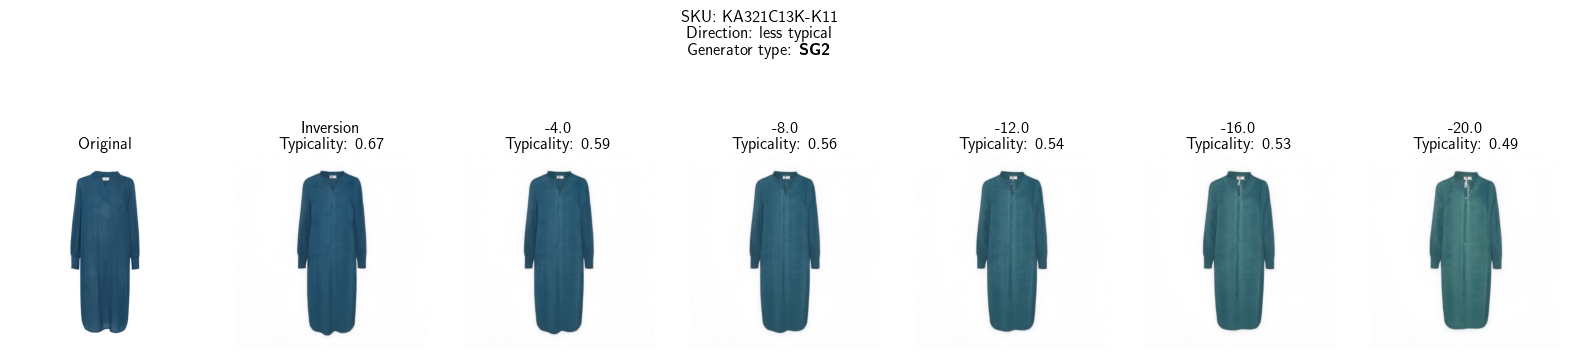

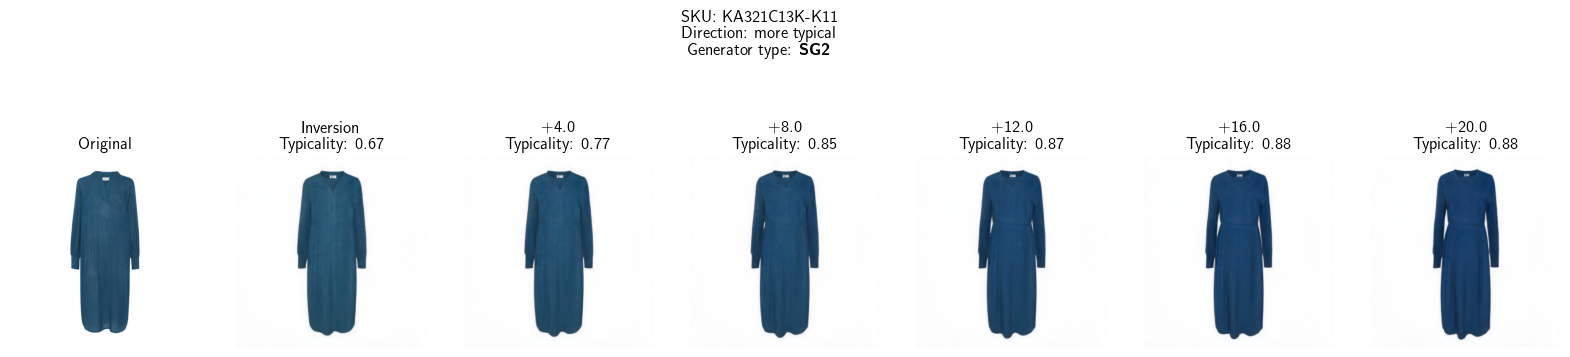

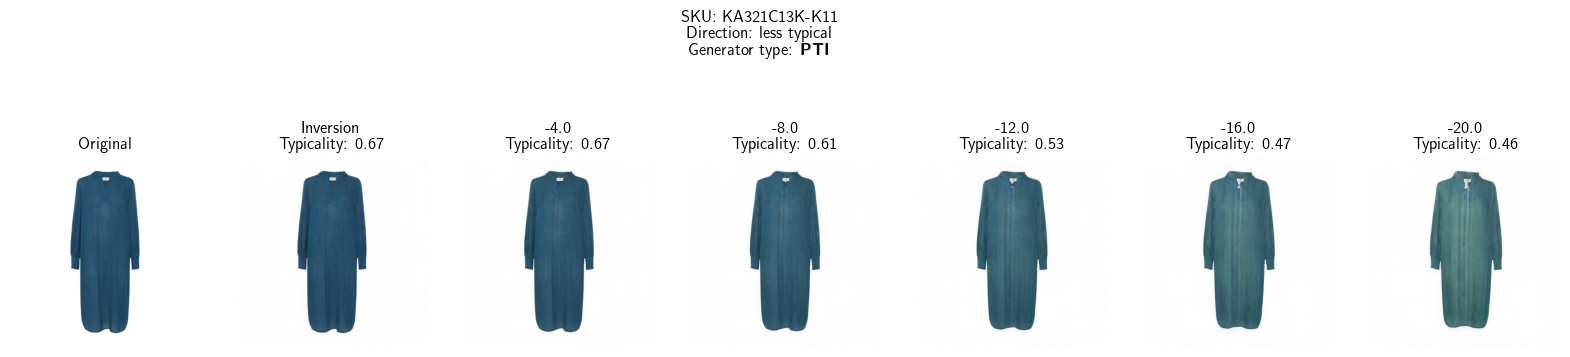

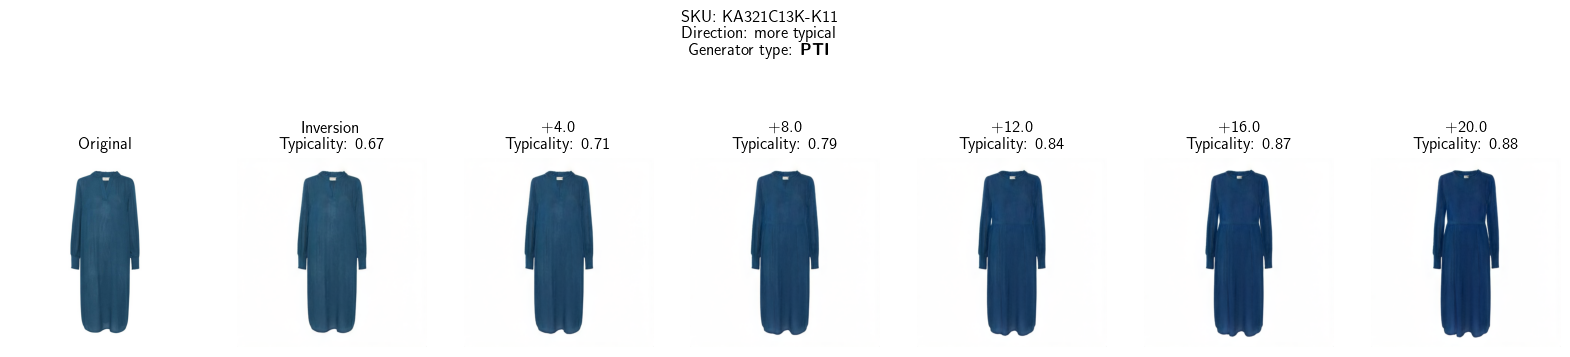


********************************************************************************************************************************************************************************************************



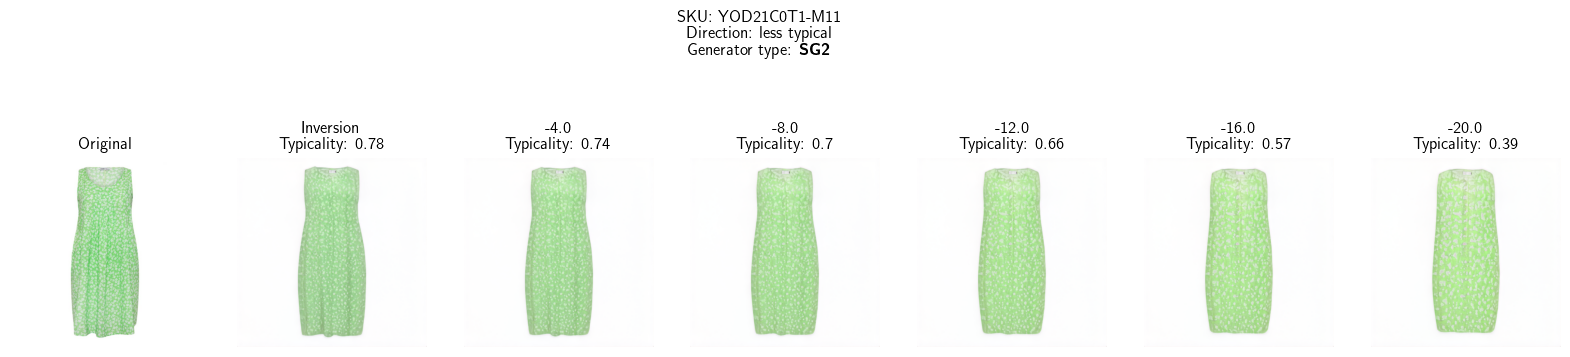

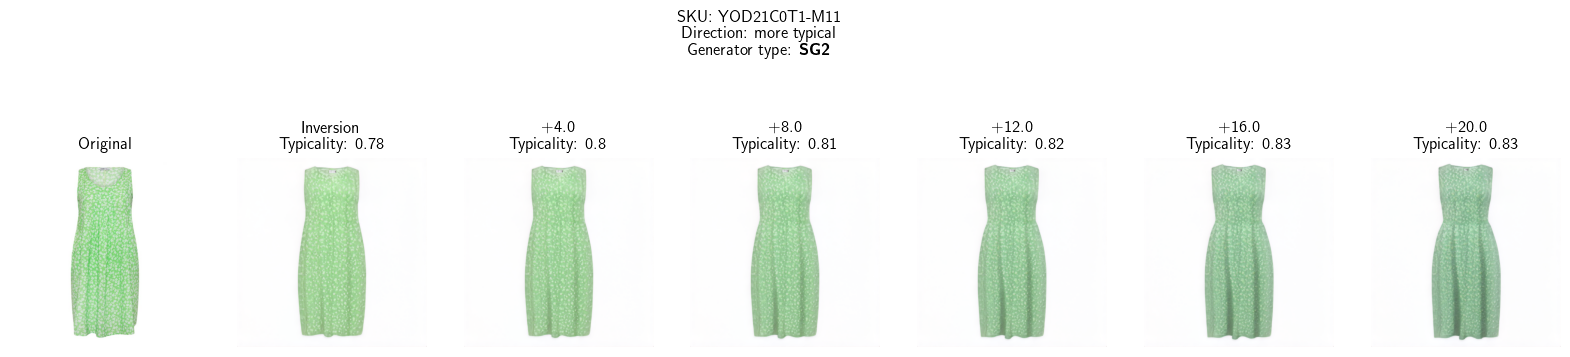

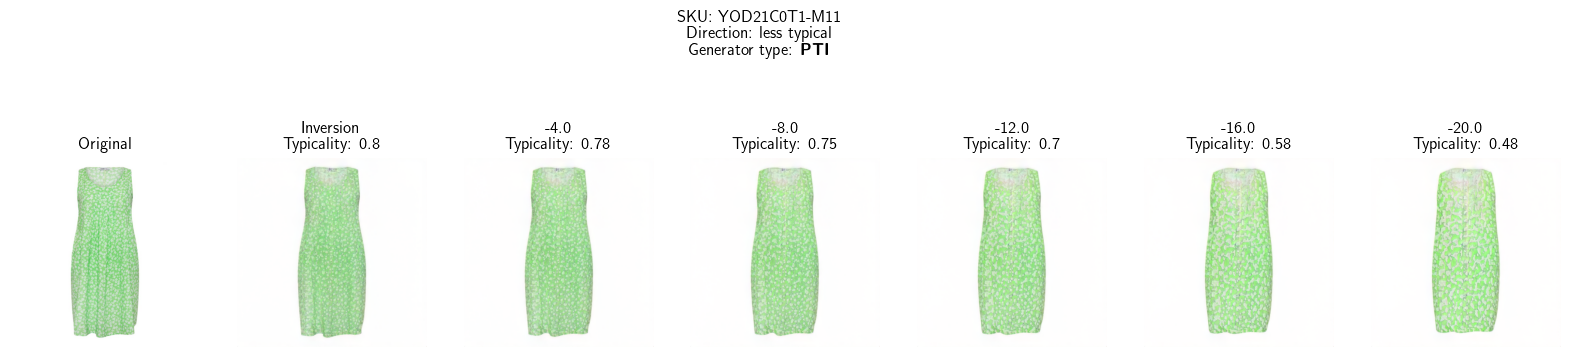

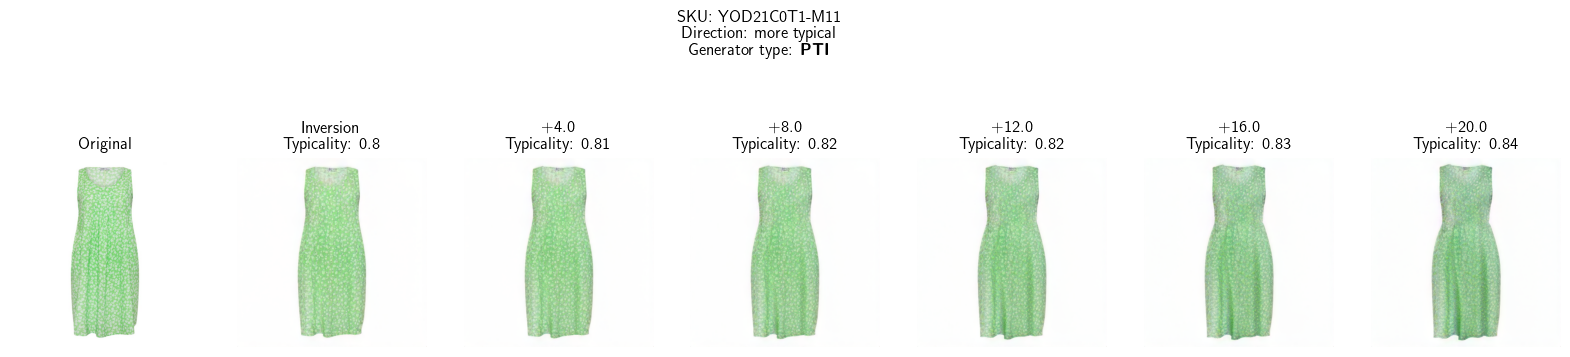


********************************************************************************************************************************************************************************************************



In [17]:
%matplotlib inline
for elem in chosen_articles:
    run_example(n = 1000, direction = 'less', steps=6, distance=20, sku = elem,  generator = 'SG2')
    run_example(n = 1000, direction = 'more', steps=6, distance=20, sku = elem, generator = 'SG2')
    run_example(n = 1000, direction = 'less', steps=6, distance=20, sku = elem, generator = 'PTI')
    run_example(n = 1000, direction = 'more', steps=6, distance=20, sku = elem, generator = 'PTI')
    print(f"\n{'*'*200}\n")

## Conditional Manipulations

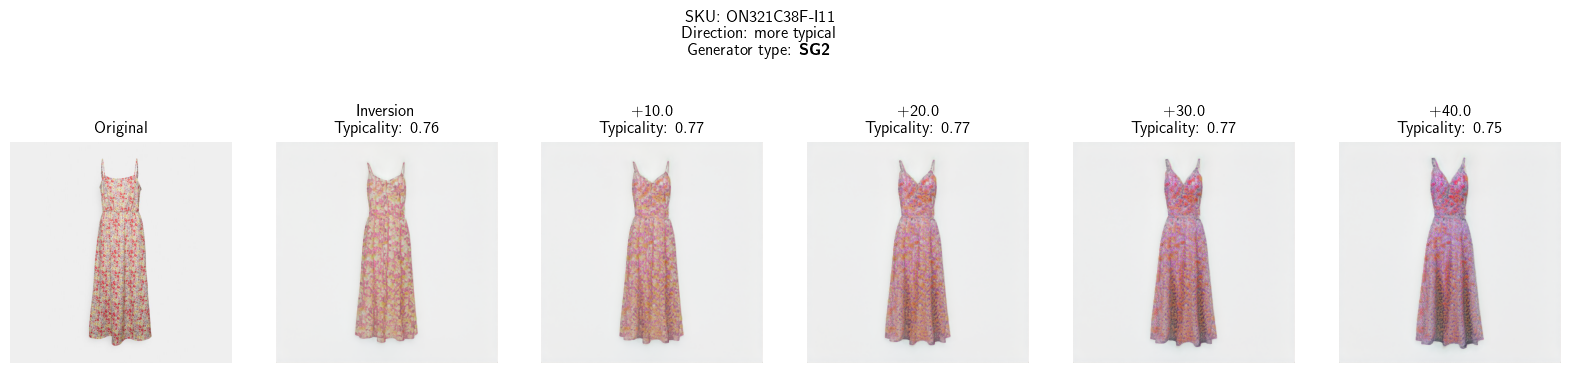

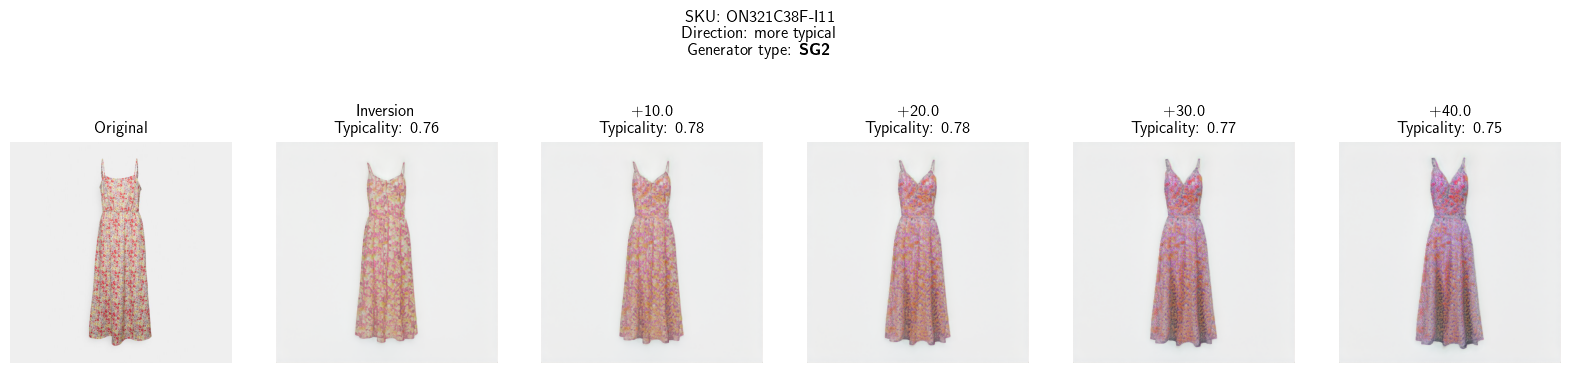

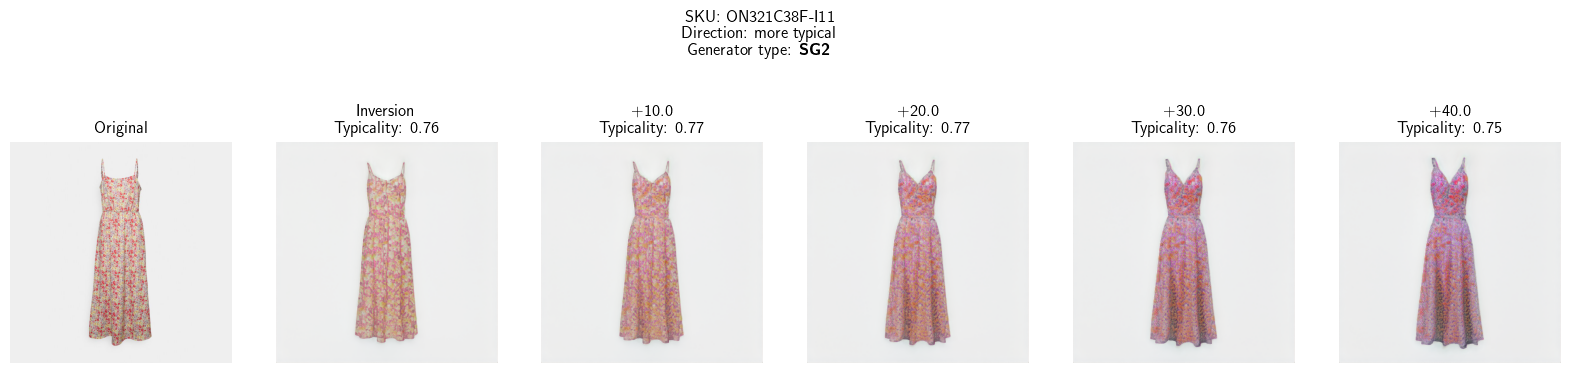

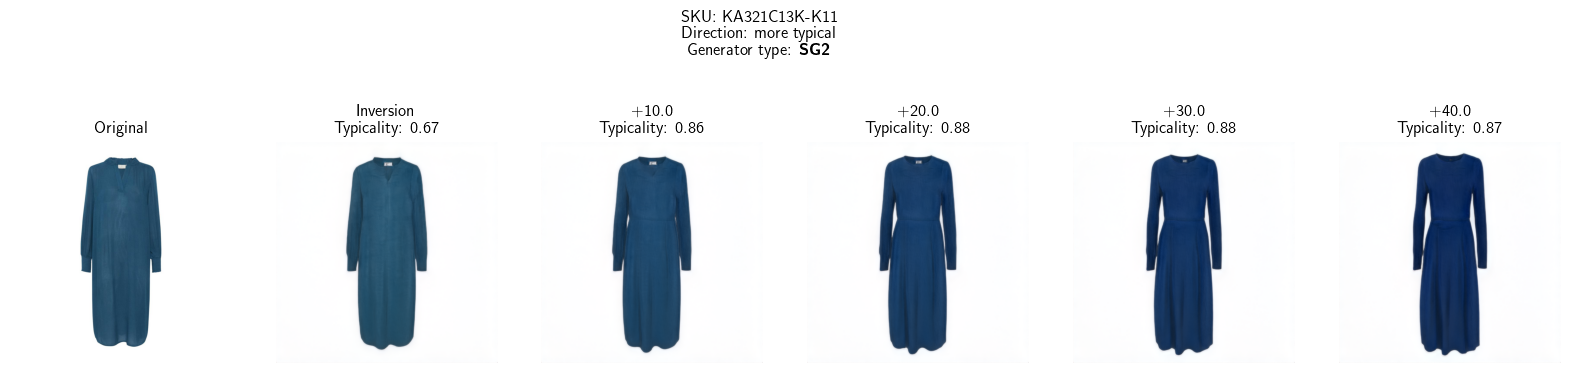

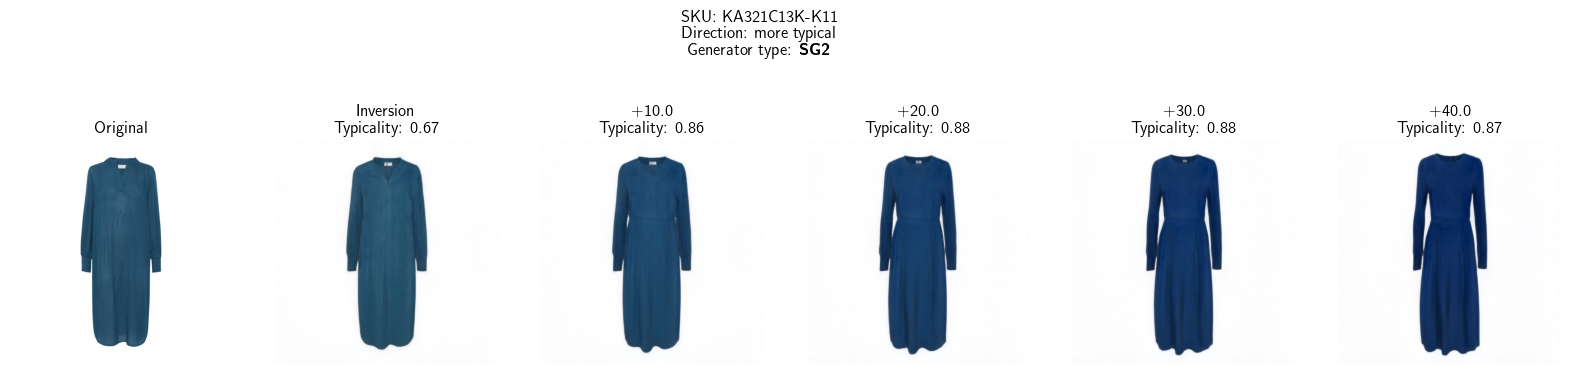

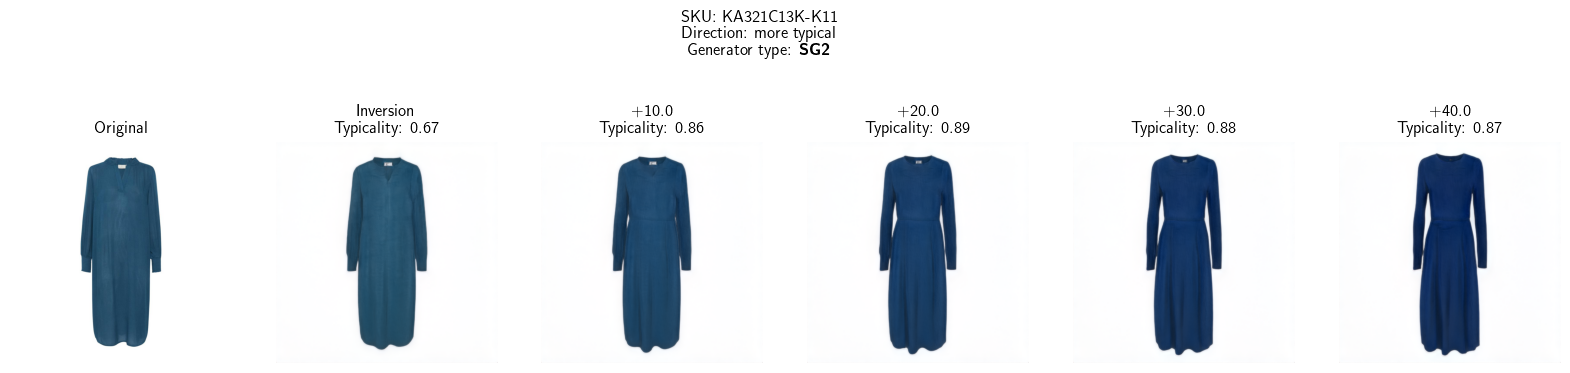

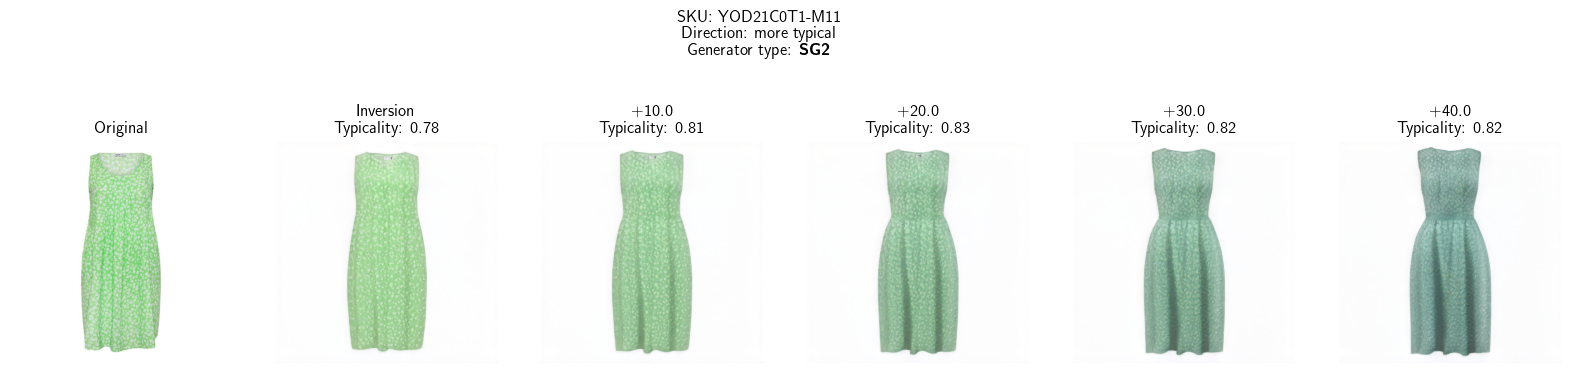

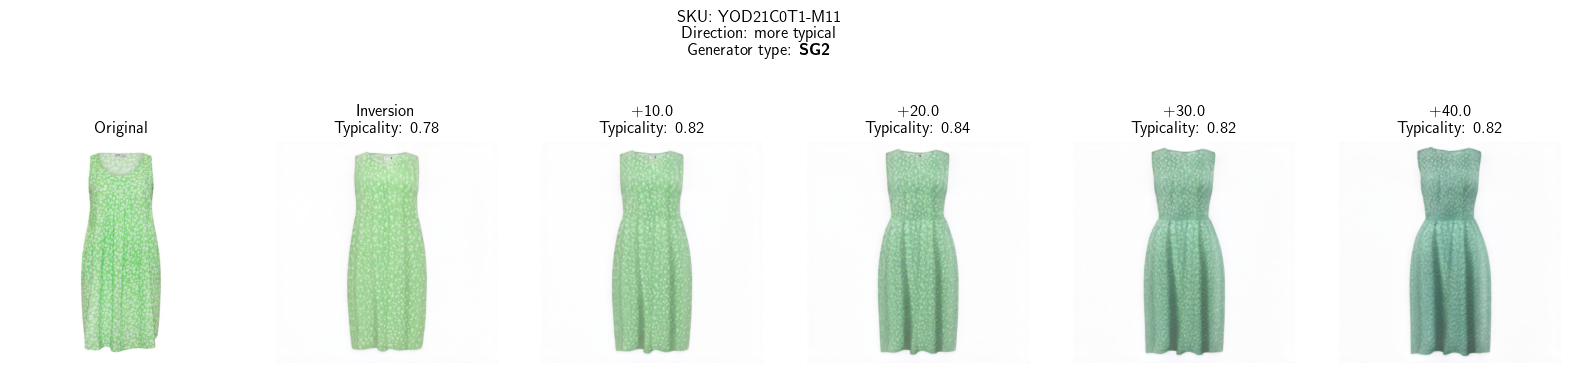

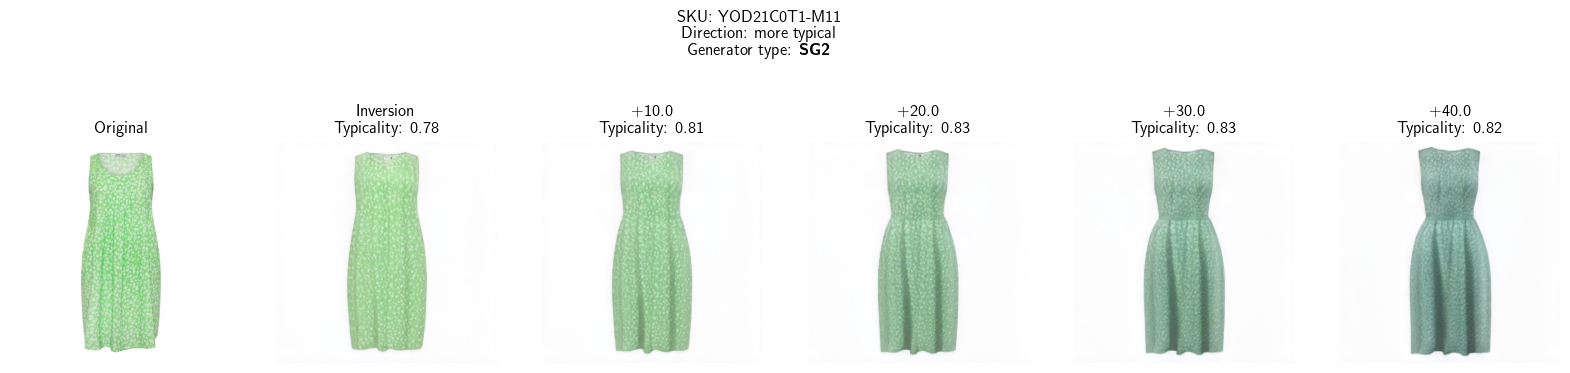

In [20]:
for elem in chosen_articles:
    run_example(n=1000, direction = 'more', steps = 5, distance = 40, sku = elem, generator = 'SG2')
    run_example(n=1000, direction = 'more', steps = 5, distance = 40, sku = elem, generator = 'SG2', condition='color')
    run_example(n=1000, direction = 'more', steps = 5, distance = 40, sku = elem, generator = 'SG2', condition='sleeve_length')
